## SCAO tip tilt map using Zernike covariance

In the following example, we plot the tip/tilt map that we expect from a SCAO configuration, i.e. correcting tip/tilt modes in the field of view with one NGS. \
The sources are elongated ellipses in the NGS's direction. Axes' length and orientation of each ellipse are obtained from tip/tilt covariance matrix computed between the NGS and the considered source.

In [1]:
def computeOffAxisError(covOnOn, covOnOff):
        return 2 * (covOnOn - covOnOff)
    
    
def getOffAxisErrorFromNGS(j_mode, k_mode,
                           distances_from_NGS, ngs_source,
                           ap1, ap2, profile, freqs_vector):
    vk = VonKarmanSpatioTemporalCovariance(source1=ngs_source, source2=ngs_source, aperture1=ap1, aperture2=ap2,
                                           cn2_profile=profile, spat_freqs=freqs_vector)
    ngs_covariance = (vk.getZernikeCovariance(j_mode, k_mode).value).real
    
    residualsList = []
    for coords in distances_from_NGS:
        source = GuideSource(coords, np.inf)
        vk.setSource2(source)
        on_off_covariance = (vk.getZernikeCovariance(j_mode, k_mode).value).real
        res = computeOffAxisError(ngs_covariance, on_off_covariance)
        residualsList.append(res)
    return residualsList


def ellipsePlot(distances_xy, width, height, angle,
                x_max, x_min, y_max, y_min, scale=2):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib.patches import Ellipse
    
    mpl.rcParams['figure.dpi'] = 200
    ellipse = [Ellipse((distances_xy[i, 0], distances_xy[i, 1]),
                       width[i]/scale, height[i]/scale, angle=angle[i]) for i in range(len(width))]
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    for e in ellipse:
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        
def getCartesianPositions(rho, theta):
    x = rho * np.cos(np.deg2rad(theta))
    y = rho * np.sin(np.deg2rad(theta))
    return x, y


def computeEllipseParameters(tip_tip_res, tilt_tilt_res, tip_tilt_res, nstd=1):
    covariance_matrix = np.array([[tip_tip_res, tip_tilt_res], [tip_tilt_res, tilt_tilt_res]])
    eig_values, eig_vectors = np.linalg.eigh(covariance_matrix)
    order = eig_values.argsort()[::-1]
    val_sort, vect_sort = eig_values[order], eig_vectors[:, order]
    theta = np.rad2deg(np.arctan2(vect_sort[:, 0][1], vect_sort[:, 0][0]))
    width, height = 2 * nstd * np.sqrt(val_sort)
    return width, height, theta

In [2]:
import numpy as np
from apposto.types.guide_source import GuideSource
from apposto.types.aperture import CircularOpticalAperture
from apposto.atmo.cn2_profile import Cn2Profile
from apposto.atmo.von_karman_covariance_calculator import VonKarmanSpatioTemporalCovariance

#Initialization of NGS's position, apertures' positions, turbulence profile and spatial frequencies array.
rhoNGS = 0
thetaNGS = 0
ngs = GuideSource((rhoNGS, thetaNGS), np.inf)
aperture1 = CircularOpticalAperture(5, [0, 0, 0])
aperture2 = CircularOpticalAperture(5, [0, 0, 0])
cn2_profile = Cn2Profile.from_r0s([0.1], [np.inf], [10e3], [10], [-20])
#cn2_profile.set_wavelength(2.2e-6)
spatial_freqs = np.logspace(-3, 3, 100)

#Definition of off-axis stars' positions.
rhos = np.random.randint(-50, 50, size=(200))
thetas = np.random.randint(360, size=(200))
#thetas = np.zeros(500)
positionsInPolar = np.stack((rhos, thetas), axis=-1)

#Computation of tip/tilt residuals.
res22 = getOffAxisErrorFromNGS(j_mode=2, k_mode=2, distances_from_NGS=positionsInPolar,
                                  ngs_source=ngs, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                  freqs_vector=spatial_freqs)
res33 = getOffAxisErrorFromNGS(j_mode=3, k_mode=3, distances_from_NGS=positionsInPolar,
                                  ngs_source=ngs, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                  freqs_vector=spatial_freqs)
res23 = getOffAxisErrorFromNGS(j_mode=2, k_mode=3, distances_from_NGS=positionsInPolar,
                                  ngs_source=ngs, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                  freqs_vector=spatial_freqs)

print(res22[0])

6.411782781405691


Run this cell if you want to compute the residuals with CPSD too.

In [4]:
#from apposto.sandbox import ResidualSCAOVarianceUsingOffAxisNGS
import astropy.units as u
from apposto.utils.residual_calculator import ResidualCalculator
from apposto.utils.integrator import Integrator

# RTF = 0
# NTF = -1
temp_freqs = np.logspace(-3, 3, 1000)

integrator = Integrator()
integrator.setRejectionTransferFunction(0)
integrator.setNoiseTransferFunction(-1)

def getResidualFromCPSD(cpsd_on_on, cpsd_on_off, temp_freqs, noise=0):
    rc = ResidualCalculator(cpsd_on_on, cpsd_on_off, noise, integrator)
    res_with_cpsd = rc.getSCAOResidual(temp_freqs*u.Hz)
    return res_with_cpsd.value

def getOffAxisErrorFromNGSUsingCPSD(j_mode, k_mode, distances_from_NGS, ngs_source,
                                   ap1, ap2, profile, freqs_vector, temp_vector):
    vk = VonKarmanSpatioTemporalCovariance(source1=ngs_source, source2=ngs_source, aperture1=ap1, aperture2=ap2,
                                          cn2_profile=profile, spat_freqs=freqs_vector)
    cpsd_ngs = (vk.getGeneralZernikeCPSD(j_mode, k_mode, temp_vector).value).real
    residualsList = []
    for coords in distances_from_NGS:
        source = GuideSource(coords, np.inf)
        vk.setSource2(source)
        cpsd_on_off = (vk.getGeneralZernikeCPSD(j_mode, k_mode, temp_vector).value).real
        res = getResidualFromCPSD(cpsd_ngs, cpsd_on_off, temp_vector)
        residualsList.append(res)
    return residualsList

res22_withCPSD = getOffAxisErrorFromNGSUsingCPSD(j_mode=2, k_mode=2, distances_from_NGS=positionsInPolar,
                                     ngs_source=ngs, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                     freqs_vector=spatial_freqs, temp_vector=temp_freqs)
res23_withCPSD = getOffAxisErrorFromNGSUsingCPSD(j_mode=2, k_mode=3, distances_from_NGS=positionsInPolar,
                                     ngs_source=ngs, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                     freqs_vector=spatial_freqs, temp_vector=temp_freqs)
res33_withCPSD = getOffAxisErrorFromNGSUsingCPSD(j_mode=3, k_mode=3, distances_from_NGS=positionsInPolar,
                                     ngs_source=ngs, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                     freqs_vector=spatial_freqs, temp_vector=temp_freqs)

Text(0, 0.5, 'arcsec')

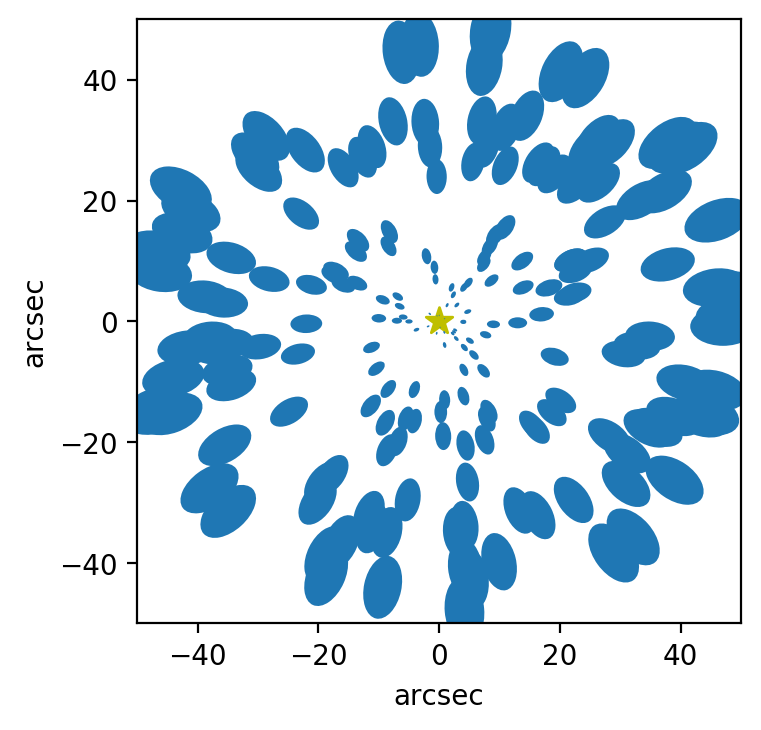

In [6]:
# Computation of covariance ellipses' parameters.
positionsInXY = np.stack(getCartesianPositions(rhos, thetas), axis=-1)
widths_withCPSD = []
heights_withCPSD = []
ths_withCPSD = []
for i in range(len(res22_withCPSD)):
    w, h, t = computeEllipseParameters(res22_withCPSD[i], res33_withCPSD[i], res23_withCPSD[i], nstd=1)
    widths_withCPSD.append(w)
    heights_withCPSD.append(h)
    ths_withCPSD.append(t)

#Plot of the tip tilt map (field in XY coordinates).
import matplotlib.pyplot as plt
ellipsePlot(distances_xy=positionsInXY, width=widths_withCPSD, height=heights_withCPSD, angle=ths_withCPSD,
            x_max=50, x_min=-50, y_max=50, y_min=-50)

xNGS, yNGS = getCartesianPositions(rhoNGS, thetaNGS)
plt.scatter(xNGS, yNGS, marker='*', s=100, color='y')
plt.xlabel('arcsec')
plt.ylabel('arcsec')

Text(0, 0.5, 'arcsec')

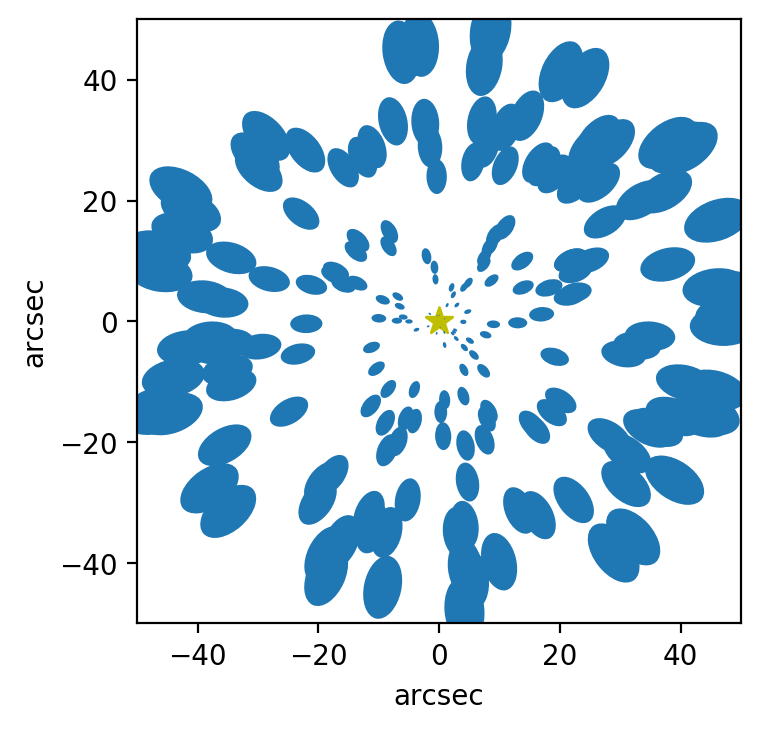

In [7]:
#Computation of covariance ellipses' parameters.
positionsInXY = np.stack(getCartesianPositions(rhos, thetas), axis=-1)
widths = []
heights = []
ths = []
for i in range(len(res22)):
    w, h, t = computeEllipseParameters(res22[i], res33[i], res23[i], nstd=1)
    widths.append(w)
    heights.append(h)
    ths.append(t)

#Plot of the tip tilt map (field in XY coordinates).
import matplotlib.pyplot as plt
ellipsePlot(distances_xy=positionsInXY, width=widths, height=heights, angle=ths,
            x_max=50, x_min=-50, y_max=50, y_min=-50)

xNGS, yNGS = getCartesianPositions(rhoNGS, thetaNGS)
plt.scatter(xNGS, yNGS, marker='*', s=100, color='y')
plt.xlabel('arcsec')
plt.ylabel('arcsec')

## Test Sandler's formula for differential tilt jitter

We now verify if the computed ellipses follow the behavior of differential tilt jitter (i.e. if $\sigma_{\parallel} \sim \sqrt{3}\sigma_{\perp}$).

In [8]:
#widths_withCPSD = []
#heights_withCPSD = []
#ths_withCPSD = []
#for i in range(len(res22)):
#    w, h, t = computeEllipseParameters(res22[i], res33[i], res23[i])
#    widths_withCPSD.append(w/2)
#    heights_withCPSD.append(h/2)
#    ths_withCPSD.append(t)
    
#plt.figure()
#plt.plot(distancesFromNGS[order], np.array(widths_withCPSD)[order], '.', label="$\sigma_{\parallel}$")
#plt.plot(distancesFromNGS[order], np.array(heights_withCPSD)[order], '.',  label="$\sigma_{\perp}$")
#plt.xlabel('Distance from NGS [arcsec]')
#plt.ylabel('$\sigma$ [$rad_{\phi}]$')

#plt.plot(distancesFromNGS[order], np.array(widths)[order], '.', label="$\sigma_{\parallel}$")
#plt.plot(distancesFromNGS[order], np.array(heights)[order], '.',  label="$\sigma_{\perp}$")

0.01031325
0.6476903063533166
32.38451531766583
64.76903063533166


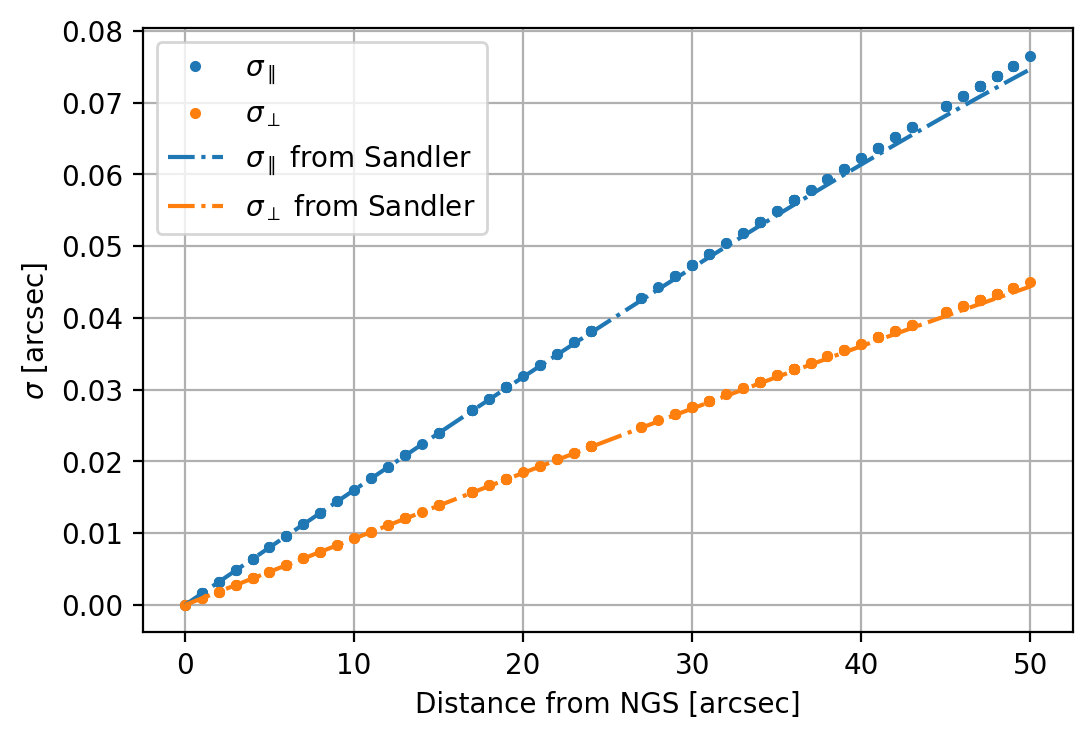

In [9]:
posNGSInXY = np.stack((np.ones(positionsInXY.shape[0])*xNGS, np.ones(positionsInXY.shape[0])*yNGS), axis=-1)
distancesFromNGS = np.linalg.norm(posNGSInXY - positionsInXY, axis=1)
order = distancesFromNGS.argsort()

D = 2 * aperture1.getApertureRadius().value
wlength = cn2_profile.wavelength().value
r0 = cn2_profile.r0().value
theta0 = cn2_profile.theta0().value
#th0 = 0.057 * wlength**(6/5)*cn2_profile.airmass()**(-8/5)* \
#     (np.sum(cn2_profile._layersJs*cn2_profile._layersAltitudeInMeterAtZenith**(5/3)))**(-3/5) * radToArcsec

radToArcsec = 206265
widthArcsec = np.array(widths) * 4 * wlength / (2 * np.pi * D) * radToArcsec
heightArcsec = np.array(heights) * 4 * wlength / (2 * np.pi * D) * radToArcsec
sigma_para = widthArcsec / 2
sigma_perp = heightArcsec / 2

c1_para = 0.0472 * (D/r0)**(-1/3) / theta0**2 * (wlength / D)**2
c2_para = -0.0107 * (D/r0)**(-7/3) / theta0**4 * (wlength / D)**2
c1_perp = 0.0157 * (D/r0)**(-1/3) / (theta0**2) * (wlength / D)**2
c2_perp = -0.00214 * (D/r0)**(-7/3) / theta0**4 * (wlength / D)**2
sandler_para = np.sqrt(c1_para * distancesFromNGS[order]**2 + c2_para * distancesFromNGS[order]**4) * radToArcsec
sandler_perp = np.sqrt(c1_perp * distancesFromNGS[order]**2 + c2_perp * distancesFromNGS[order]**4) * radToArcsec

import matplotlib.pyplot as plt
plt.figure()
plt.plot(distancesFromNGS[order], sigma_para[order], '.', label="$\sigma_{\parallel}$")
plt.plot(distancesFromNGS[order], sigma_perp[order], '.',  label="$\sigma_{\perp}$")

plt.xlabel('Distance from NGS [arcsec]')
plt.ylabel('$\sigma$ [arcsec]')

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.plot(distancesFromNGS[order], sandler_para, '-.', color = cycle[0], label='$\sigma_{\parallel}$ from Sandler')
plt.plot(distancesFromNGS[order], sandler_perp, '-.', color=cycle[1], label='$\sigma_{\perp}$ from Sandler')
plt.legend()
plt.grid()


print(wlength/D * radToArcsec)
print(theta0)
#print(th0)

print(0.5 * D / r0 * theta0)
print(D / r0 * theta0)

## SCAO residual from CPSD and transfer functions

In [10]:
import numpy as np
from apposto.types.guide_source import GuideSource
from apposto.types.aperture import CircularOpticalAperture
from apposto.atmo.cn2_profile import Cn2Profile
from apposto.atmo.von_karman_covariance_calculator import VonKarmanSpatioTemporalCovariance

#Initialization of NGS's position, apertures' positions, turbulence profile and spatial frequencies array.
target = GuideSource((0, 0), np.inf)
aperture1 = CircularOpticalAperture(5, [0, 0, 0])
aperture2 = CircularOpticalAperture(5, [0, 0, 0])
cn2_profile = Cn2Profile.from_r0s([0.16], [25], [10e3], [10], [-20])
spatial_freqs = np.logspace(-4, 4, 1000)
temp_freqs = np.logspace(-3, 3, 1000)

vk = VonKarmanSpatioTemporalCovariance(source1=target, source2=target, aperture1=aperture1, aperture2=aperture2,
                                           cn2_profile=cn2_profile, spat_freqs=spatial_freqs)

cov_on_on = vk.getZernikeCovariance(2, 2)
cpsd_on_on = vk.getGeneralZernikeCPSD(2, 2, temp_freqs)

ngs = GuideSource((50,30), np.inf)
vk.setSource2(ngs)
cov_on_off = vk.getZernikeCovariance(2, 2)
cpsd_on_off = vk.getGeneralZernikeCPSD(2, 2, temp_freqs)

In [13]:
res_with_cov = 2 * (cov_on_on - cov_on_off)

from apposto.utils.residual_calculator import ResidualCalculator
from apposto.utils.integrator import Integrator
import astropy.units as u

ig = Integrator()
ig.setRejectionTransferFunction(0)
ig.setNoiseTransferFunction(-1)
# RTF = 0
# NTF = -1
rc = ResidualCalculator(cpsd_on_on, cpsd_on_off, 0, ig)
res_with_cpsd = rc.getSCAOResidual(temp_freqs*u.Hz)

In [14]:
print('Residual from covariance: {}'.format(res_with_cov))
print('Residual from CPSD and TF: {}'.format(res_with_cpsd))
print('Ratio: {}'.format(res_with_cov/res_with_cpsd))

Residual from covariance: (25.9466544734222+0j) rad2
Residual from CPSD and TF: (25.913265528506056+0j) rad2
Ratio: (1.0012884885110067+0j)


## Spatial residual with 2 NGSs

In [4]:
import numpy as np
from apposto.types.guide_source import GuideSource
from apposto.types.aperture import CircularOpticalAperture
from apposto.atmo.cn2_profile import Cn2Profile
from apposto.atmo.von_karman_covariance_calculator import VonKarmanSpatioTemporalCovariance

#Initialization of NGS's position, apertures' positions, turbulence profile and spatial frequencies array.
D = 10
r0 = 0.16
L0 = np.inf
layer_alt = 10e3
v_wind = 10
th_wind = -20
aperture1 = CircularOpticalAperture(D/2, [0, 0, 0])
aperture2 = CircularOpticalAperture(D/2, [0, 0, 0])
cn2_profile = Cn2Profile.from_r0s([r0], [L0], [layer_alt], [v_wind], [th_wind])
#cn2_profile.set_wavelength(2.2e-6)
spatial_freqs = np.logspace(-3, 3, 100)

rho1, theta1 = (30, 30)
ngs_1 = GuideSource((rho1, theta1), np.inf)
rho2, theta2 = (30, 0)
ngs_2 = GuideSource((rho2, theta2), np.inf)

rhos_stars = np.random.randint(-50, 50, size=(500))
thetas_stars = np.random.randint(360, size=(500))
positionsInPolar = np.stack((rhos_stars, thetas_stars), axis=-1)

#Computation of tip/tilt residuals.
res22_ngs1 = getOffAxisErrorFromNGS(j_mode=2, k_mode=2, distances_from_NGS=positionsInPolar,
                                  ngs_source=ngs_1, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                  freqs_vector=spatial_freqs)
res33_ngs1 = getOffAxisErrorFromNGS(j_mode=3, k_mode=3, distances_from_NGS=positionsInPolar,
                                  ngs_source=ngs_1, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                  freqs_vector=spatial_freqs)
res23_ngs1 = getOffAxisErrorFromNGS(j_mode=2, k_mode=3, distances_from_NGS=positionsInPolar,
                                  ngs_source=ngs_1, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                  freqs_vector=spatial_freqs)

res22_ngs2 = getOffAxisErrorFromNGS(j_mode=2, k_mode=2, distances_from_NGS=positionsInPolar,
                                  ngs_source=ngs_2, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                  freqs_vector=spatial_freqs)
res33_ngs2 = getOffAxisErrorFromNGS(j_mode=3, k_mode=3, distances_from_NGS=positionsInPolar,
                                  ngs_source=ngs_2, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                  freqs_vector=spatial_freqs)
res23_ngs2 = getOffAxisErrorFromNGS(j_mode=2, k_mode=3, distances_from_NGS=positionsInPolar,
                                  ngs_source=ngs_2, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                  freqs_vector=spatial_freqs)

In [5]:
res_range = len(res22_ngs1)
res22_tot = np.array([res22_ngs1[i] + res22_ngs2[i] for i in range(res_range)])
res23_tot = np.array([res23_ngs1[i] + res23_ngs2[i] for i in range(res_range)])
res33_tot = np.array([res33_ngs1[i] + res33_ngs2[i] for i in range(res_range)])

Text(0, 0.5, 'arcsec')

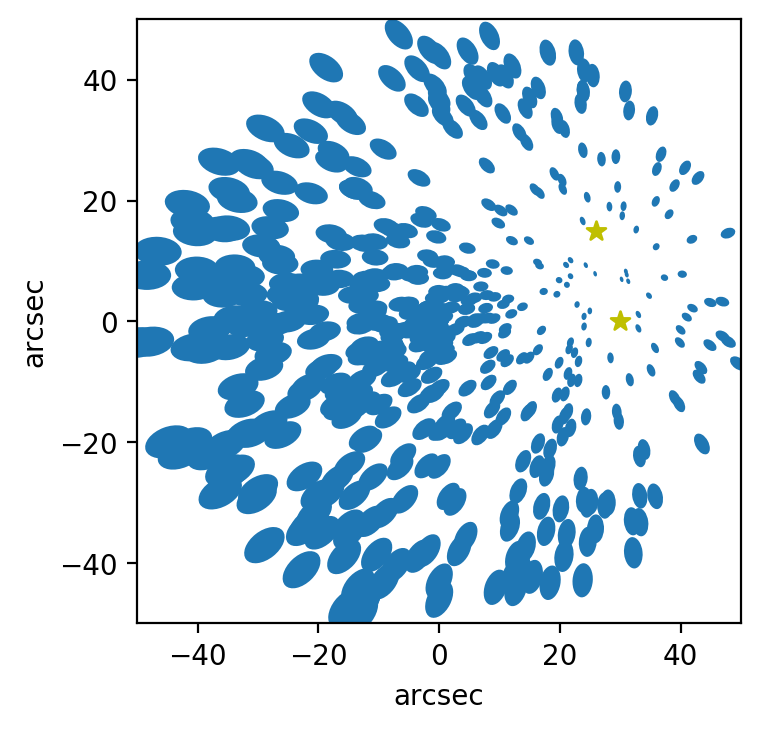

In [7]:
#Computation of covariance ellipses' parameters.
positionsInXY = np.stack(getCartesianPositions(rhos_stars, thetas_stars), axis=-1)
widths = []
heights = []
ths = []
for i in range(len(res22_tot)):
    w, h, t = computeEllipseParameters(res22_tot[i], res33_tot[i], res23_tot[i], nstd=1)
    widths.append(w)
    heights.append(h)
    ths.append(t)

#Plot of the tip tilt map (field in XY coordinates).
import matplotlib.pyplot as plt
ellipsePlot(distances_xy=positionsInXY, width=widths, height=heights, angle=ths,
            x_max=50, x_min=-50, y_max=50, y_min=-50, scale=4)

x1, y1 = getCartesianPositions(rho1, theta1)
x2, y2 = getCartesianPositions(rho2, theta2)
plt.scatter(x1, y1, marker='*', s=50, color='y', zorder=2)
plt.scatter(x2, y2, marker='*', s=50, color='y', zorder=2)
plt.xlabel('arcsec')
plt.ylabel('arcsec')

In [8]:
coords_ngs_1 = np.stack((np.ones(positionsInXY.shape[0])*x1, np.ones(positionsInXY.shape[0])*y1), axis=-1)
coords_ngs_2 = np.stack((np.ones(positionsInXY.shape[0])*x2, np.ones(positionsInXY.shape[0])*y2), axis=-1)
distancesFromNGS_1 = np.linalg.norm(coords_ngs_1 - positionsInXY, axis=1)
distancesFromNGS_2 = np.linalg.norm(coords_ngs_2 - positionsInXY, axis=1)

distances_tot = np.sqrt(distancesFromNGS_1**2 + distancesFromNGS_2**2)
order = distances_tot.argsort()

32.38451531766583 arcsec
64.76903063533166 arcsec


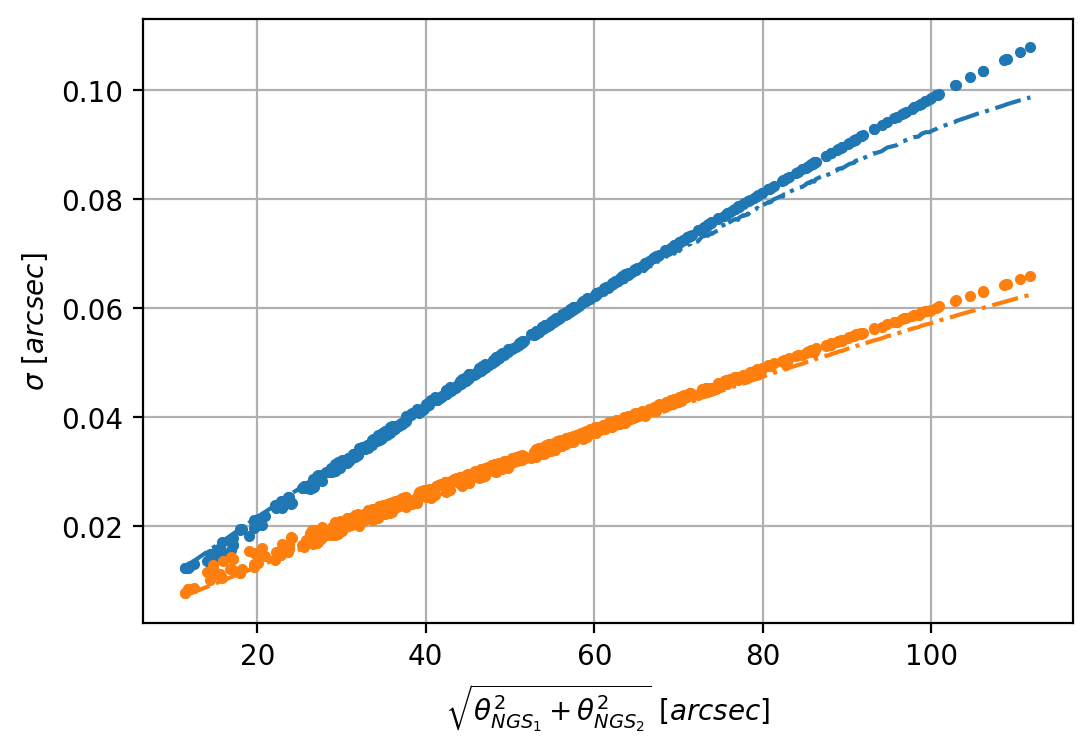

In [9]:
wlength = cn2_profile.wavelength()
r0 = cn2_profile.r0()
theta0 = cn2_profile.theta0()

import astropy.units as u
D_in_meters = D * u.m
rad_arcsec = 206265
widths_arcsec = np.array(widths) * 4 * wlength.value / (2 * np.pi * D) * rad_arcsec
heights_arcsec = np.array(heights) * 4 * wlength.value / (2 * np.pi * D) * rad_arcsec
sigma_para = widths_arcsec / 2
sigma_perp = heights_arcsec / 2

c1_para = 0.0472 * (wlength / D_in_meters)**2 * theta0**(-2) * (D_in_meters / r0)**(-1/3)
c2_para = - 0.0107 * (wlength / D_in_meters)**2 * theta0**(-4) * (D_in_meters / r0)**(-7/3)
c1_perp = 0.0157 * (wlength / D_in_meters)**2 * theta0**(-2) * (D_in_meters / r0)**(-1/3)
c2_perp = - 0.00214 * (wlength / D_in_meters)**2 * theta0**(-4) * (D_in_meters / r0)**(-7/3)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(distances_tot[order], sigma_para[order], '.', label="$\sigma_{\parallel}$")
plt.plot(distances_tot[order], sigma_perp[order], '.',  label="$\sigma_{\perp}$")

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
para_1_arcsec = (c1_para.value * distancesFromNGS_1**2 + c2_para.value * distancesFromNGS_1**4) * rad_arcsec**2
para_2_arcsec = (c1_para.value * distancesFromNGS_2**2 + c2_para.value * distancesFromNGS_2**4) * rad_arcsec**2
plt.plot(distances_tot[order], np.sqrt(para_1_arcsec + para_2_arcsec)[order], '-.', color = cycle[0])

perp_1_arcsec = (c1_perp.value * distancesFromNGS_1**2 + c2_perp.value * distancesFromNGS_1**4) * rad_arcsec**2
perp_2_arcsec = (c1_perp.value * distancesFromNGS_2**2 + c2_perp.value * distancesFromNGS_2**4) * rad_arcsec**2
plt.plot(distances_tot[order], np.sqrt(perp_1_arcsec + perp_2_arcsec)[order], '-.', color=cycle[1])

plt.xlabel('$\sqrt{\\theta_{NGS_1}^2 + \\theta_{NGS_2}^2} \ [arcsec]$')
plt.ylabel('$\sigma \ [arcsec]$')
plt.grid()

print(0.5 * D_in_meters / r0 * theta0)
print(D_in_meters / r0 * theta0)

In [30]:
c1_para = 0.0472 * (wlength / D_in_meters)**2 * theta0**(-2) * (D_in_meters / r0)**(-1/3)
c2_para = 0.0107 * (wlength / D_in_meters)**2 * theta0**(-4) * (D_in_meters / r0)**(-7/3)
print(c1_para)
print(c2_para)

2.7687297999718583e-17 1 / arcsec2
1.4961927970328832e-21 1 / arcsec4
